In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from show_chanWeights import show_chanWeights
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [26]:
col_names = [f'trial {i}' for i in range(1, 121)]
feaSubEImg_1_df = pd.read_csv('feaSubEImg_1.csv', names=col_names)
feaSubEImg_2_df = pd.read_csv('feaSubEImg_2.csv', names=col_names)
feaSubEOvert_1_df = pd.read_csv('feaSubEOvert_1.csv', names=col_names)
feaSubEOvert_2_df = pd.read_csv('feaSubEOvert_2.csv', names=col_names)
sensors102_df = pd.read_csv('sensors102.csv')
N = 120 # number of trials (data points)

In [27]:
sensors102_df

,111,-41.34388,17.135313,6,5,111.1
0,121,-33.899387,19.988480,6,5,121
1,131,-38.428867,9.101541,6,5,131
2,141,-45.259834,3.426279,6,5,141
3,211,-32.252062,8.042145,6,5,211
4,221,-25.703970,8.384077,6,5,221
...,...,...,...,...,...,...
96,2541,15.716850,-40.624069,6,5,2541
97,2611,34.167877,-3.628375,6,5,2611
98,2621,38.855766,-10.573307,6,5,2621
99,2631,34.335827,-23.072008,6,5,2631


In [28]:
X_img = pd.concat([feaSubEImg_1_df.T, feaSubEImg_2_df.T], ignore_index=True, axis=0)
X_overt = pd.concat([feaSubEOvert_1_df.T, feaSubEOvert_2_df.T], ignore_index=True, axis=0)
y = np.concatenate((np.zeros(N), np.ones(N)))

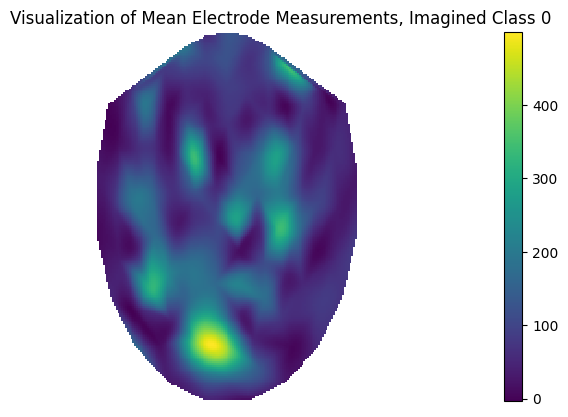

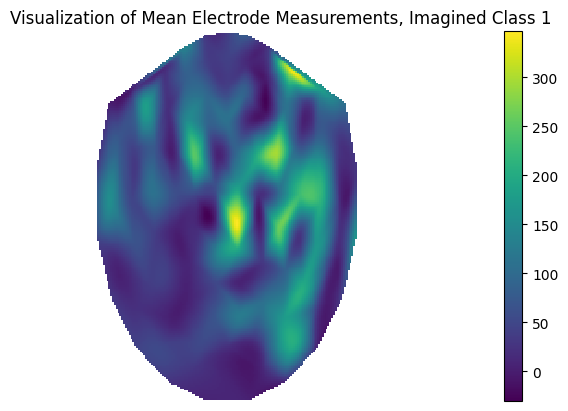

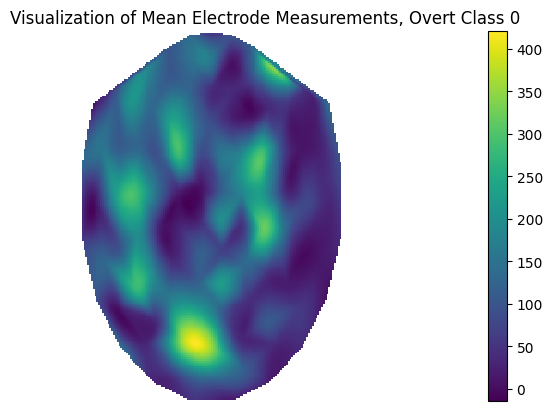

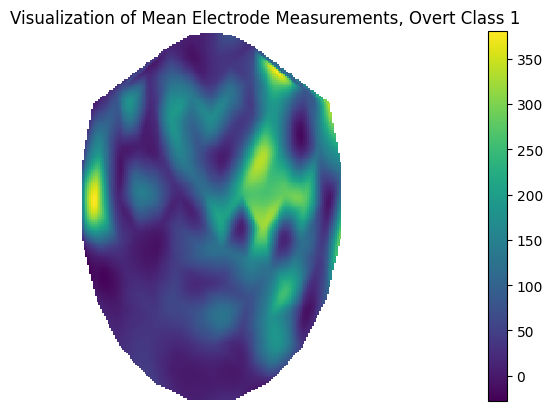

In [57]:
show_chanWeights(np.abs(np.array(X_img[y == 0].mean())), 'Visualization of Mean Electrode Measurements, Imagined Class 0')
show_chanWeights(np.abs(np.array(X_img[y == 1].mean())), 'Visualization of Mean Electrode Measurements, Imagined Class 1')
show_chanWeights(np.abs(np.array(X_overt[y == 0].mean())), 'Visualization of Mean Electrode Measurements, Overt Class 0')
show_chanWeights(np.abs(np.array(X_overt[y == 1].mean())), 'Visualization of Mean Electrode Measurements, Overt Class 1')

In [106]:
def get_cross_val_alpha(X, y, show_plots, surface_plot_title, roc_plot_title, accuracy_plot_title):
    seed = 1
    alphas = np.logspace(-10, 10, 21)
    cv_lvl_1, cv_lvl_2 = KFold(n_splits=6, shuffle=True, random_state=seed), KFold(n_splits=5, shuffle=True, random_state=seed)
    alpha_to_model = dict()
    alpha_to_accuracies = dict()
    
    for alpha in alphas:
        alpha_to_model[alpha] = LinearSVC(C=1/alpha, max_iter=10_000)
        alpha_to_accuracies[alpha] = []
        
    alpha_bests = []
    total_accuracy = 0
    
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (train_index, test_index) in enumerate(cv_lvl_1.split(X, y)):
        X_train_fold, y_train_fold = X.loc[train_index], y[train_index]
        X_test_fold, y_test_fold = X.loc[test_index], y[test_index]
        alpha_best, accuracy_best = 1, 0
        for alpha in alphas:
            cross_val_accuracy = np.mean(cross_val_score(
                estimator=alpha_to_model[alpha], 
                X=X_train_fold, 
                y=y_train_fold, 
                scoring='accuracy',
                cv=cv_lvl_2,
            ))
            alpha_to_accuracies[alpha].append(cross_val_accuracy)
            if cross_val_accuracy > accuracy_best:
                accuracy_best = cross_val_accuracy
                alpha_best = alpha
        clf_fold = alpha_to_model[alpha_best].fit(X_train_fold, y_train_fold)
        if i == 0 and show_plots:
            w = clf_fold.coef_.reshape((len(clf_fold.coef_[0])))
            show_chanWeights(np.abs(w), surface_plot_title)
            stem_plot(data=w, title='Stem Plot of Electrode Weights', xlabel='Electrode Index', ylabel='Electrode Weight')
        test_accuracy_fold = accuracy_score(y_test_fold, clf_fold.predict(X_test_fold))
        total_accuracy += test_accuracy_fold
        
        alpha_bests.append(alpha_best)
        
        if show_plots:
            fpr_fold, tpr_fold, thresholds_fold = roc_curve(y_test_fold, clf_fold.decision_function(X_test_fold))
            plt.plot(fpr_fold, tpr_fold, label=f'ROC Curve for Fold {i + 1}, accuracy={round(test_accuracy_fold, 2)}')
            tprs.append(np.interp(mean_fpr, fpr_fold, tpr_fold))
            tprs[-1][0] = 0.0
    
    alpha_optimal = np.mean(alpha_bests)
    
    if show_plots:
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        plt.plot(mean_fpr, mean_tpr, label=f'Total Cross-Validated ROC, accuracy={round(total_accuracy / 6, 2)}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(roc_plot_title)
        plt.legend()
        plt.show()
        
        mean_accuracies = []
        for alpha in alphas:
            mean_accuracies.append(np.mean(alpha_to_accuracies[alpha]))
        plt.semilogx(alphas, mean_accuracies)
        plt.axvline(alpha_optimal, linestyle='dotted', label=r'optimal $\alpha$ value selected (outer loop avg)', color='red')
        plt.xlabel(r'$\alpha$')
        plt.ylabel('accuracy')
        plt.title(accuracy_plot_title)
        plt.legend()
        plt.show()
        
    return alpha_optimal

def stem_plot(data, title, xlabel, ylabel):
    plt.stem(data, label='all weights')
    top_6_indices = np.argpartition(np.abs(data), -6)[-6:]
    plt.stem(top_6_indices, data[top_6_indices], 'orange', label='top 6')
    for i in top_6_indices:
        plt.text(i, data[i], f'{data[i]:.2e}', fontsize=7)
        print(data[i])
    plt.title(title)
    plt.ylim([1.2 * data.min(), 1.2 * data.max()])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

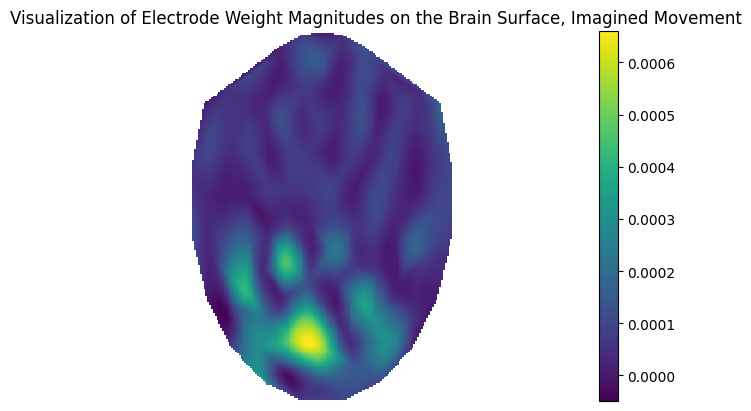

0.00041586704156231023
-0.00046095833854450246
0.00046780959557119335
0.0005395038080765599
0.0005351271937537441
0.0005705338994150717


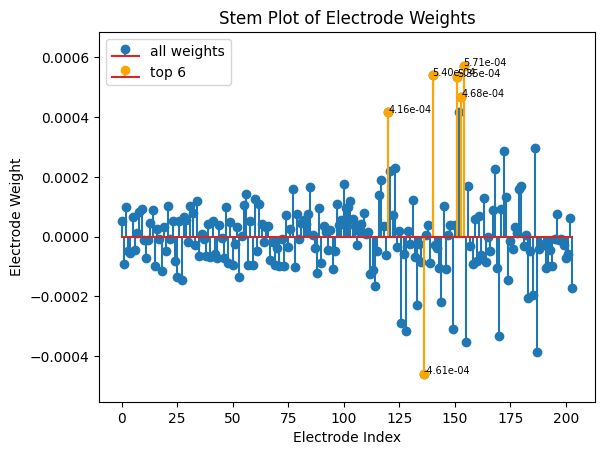

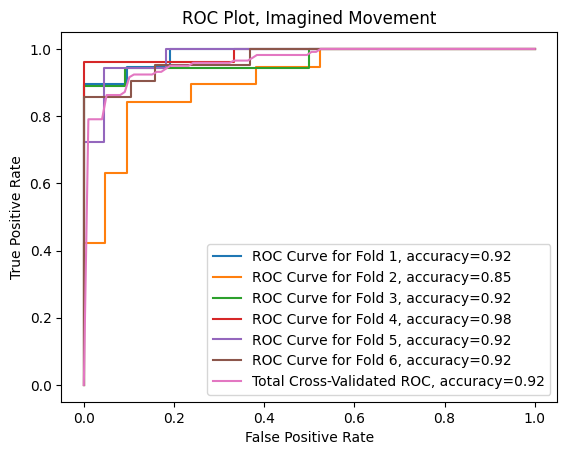

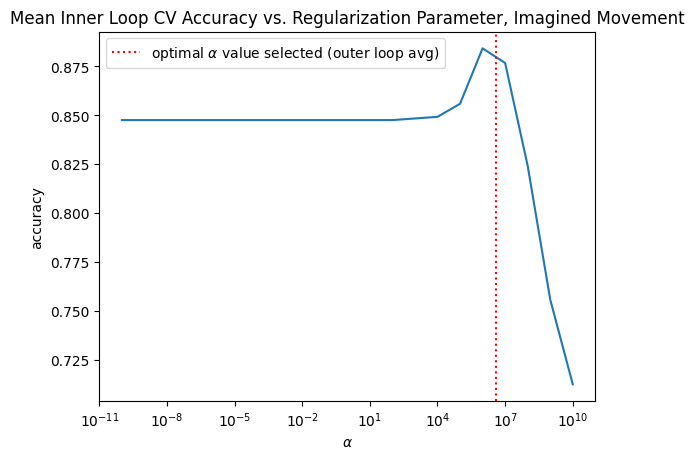

img alpha: 4000000.0


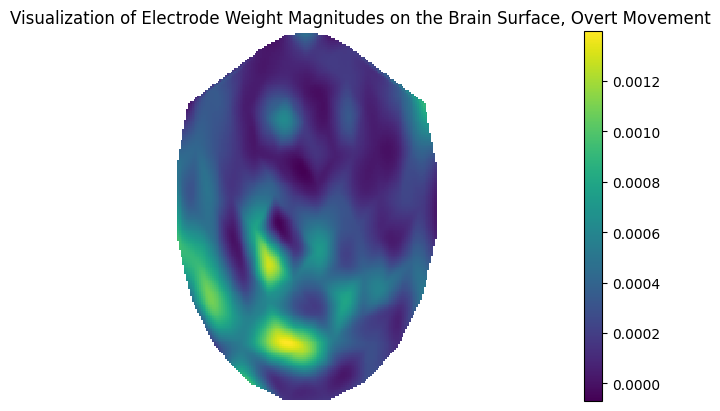

0.001011649632418103
0.0010471725405647228
-0.001157708630978954
0.0012067484406937368
0.001314827951307512
-0.0012896045774322348


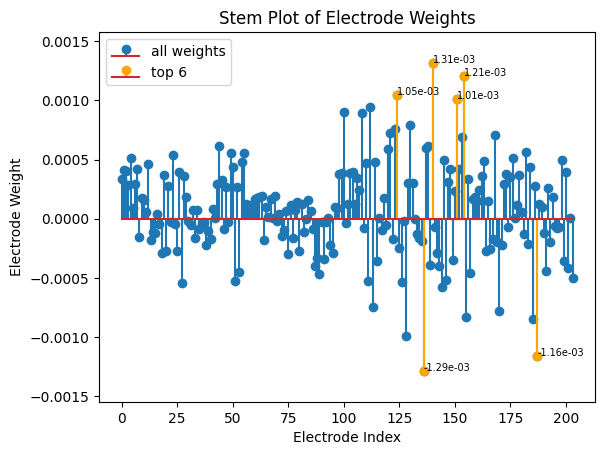

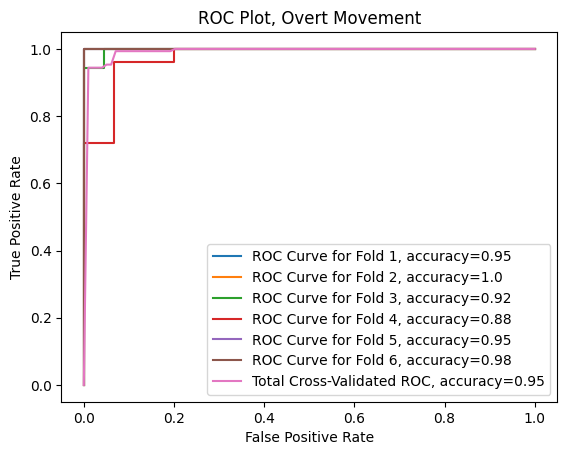

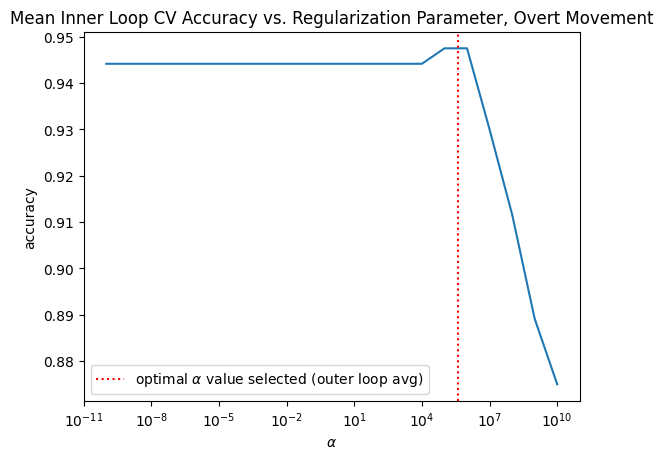

overt alpha: 383333.3333333333


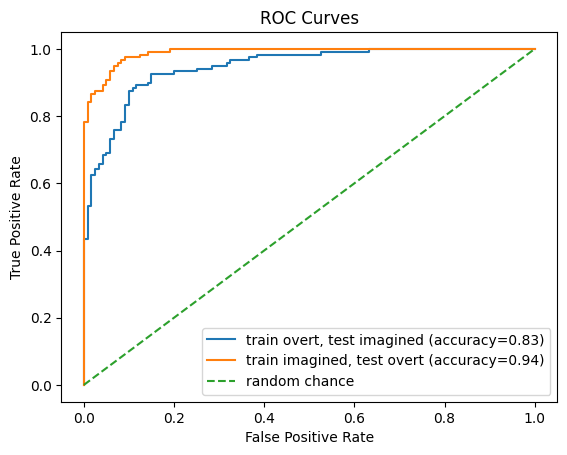

In [108]:
alpha_img = get_cross_val_alpha(X_img, y, show_plots=True, surface_plot_title='Visualization of Electrode Weight Magnitudes on the Brain Surface, Imagined Movement', roc_plot_title='ROC Plot, Imagined Movement', accuracy_plot_title='Mean Inner Loop CV Accuracy vs. Regularization Parameter, Imagined Movement') # plots are using img data
clf_img = LinearSVC(C=1/alpha_img, max_iter=15_000).fit(X_img, y) # clf named using the data it was fitted with
fpr_overt, tpr_overt, thresholds_overt = roc_curve(y, clf_img.decision_function(X_overt))
print(f'img alpha: {alpha_img}')

alpha_overt = get_cross_val_alpha(X_overt, y, show_plots=True, surface_plot_title='Visualization of Electrode Weight Magnitudes on the Brain Surface, Overt Movement', roc_plot_title='ROC Plot, Overt Movement', accuracy_plot_title='Mean Inner Loop CV Accuracy vs. Regularization Parameter, Overt Movement') # plots are using overt data
clf_overt = LinearSVC(C=1/alpha_overt, max_iter=15_000).fit(X_overt, y)
fpr_img, tpr_img, thresholds_img = roc_curve(y, clf_overt.decision_function(X_img))
print(f'overt alpha: {alpha_overt}')

plt.plot(fpr_img, tpr_img, label=f'train overt, test imagined (accuracy={round(accuracy_score(y, clf_overt.predict(X_img)), 2)})')
plt.plot(fpr_overt, tpr_overt, label=f'train imagined, test overt (accuracy={round(accuracy_score(y, clf_img.predict(X_overt)), 2)})')
plt.plot(fpr_img, fpr_img, linestyle='dashed', label='random chance')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# CHECKPOINT 1

In [9]:
def plot_electrode_values(electrode_values, plot_title):
    plt.plot(electrode_values)
    plt.title(plot_title)
    plt.xlabel('index')
    plt.ylabel('measurement')
    plt.show()

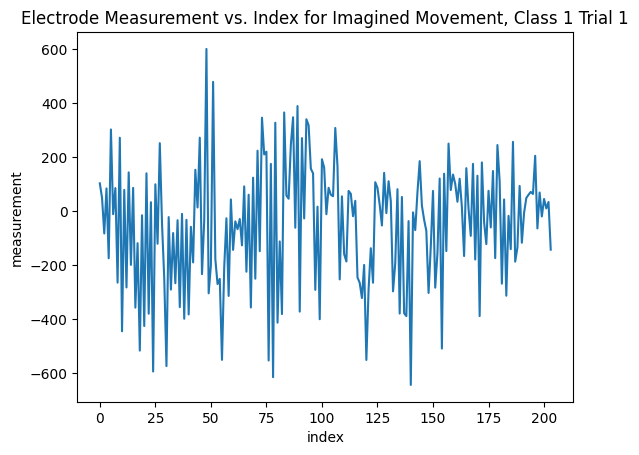

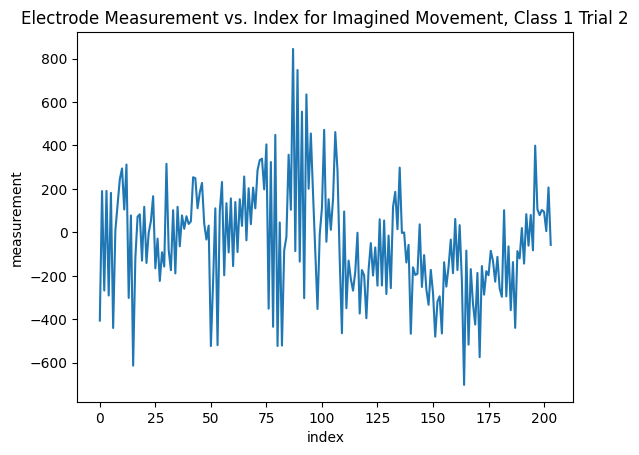

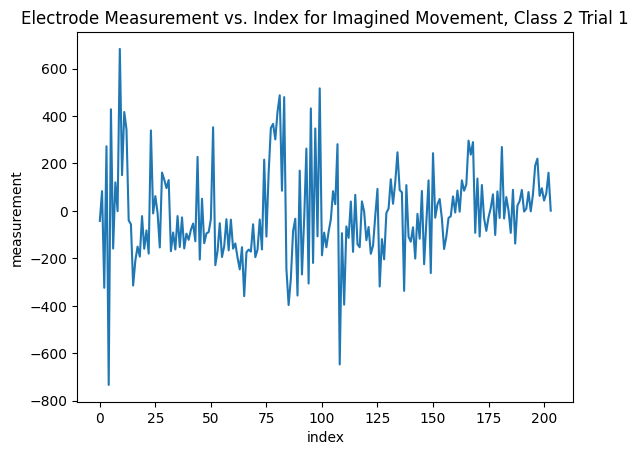

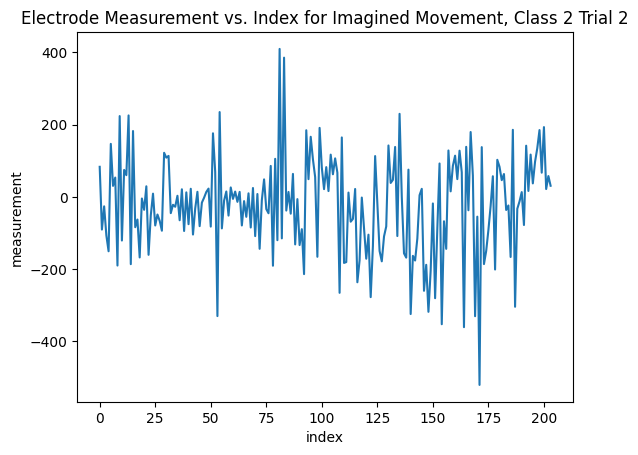

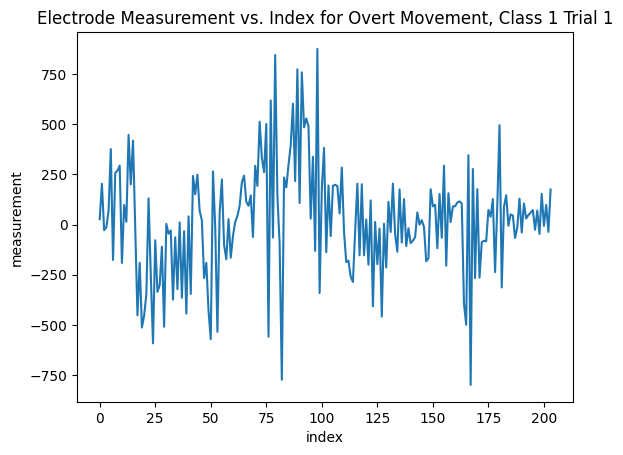

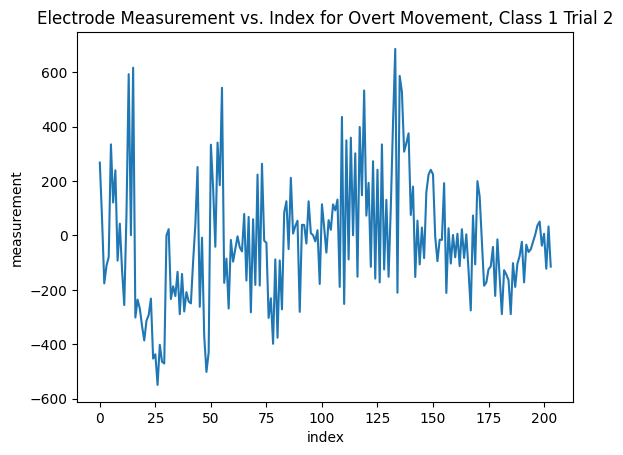

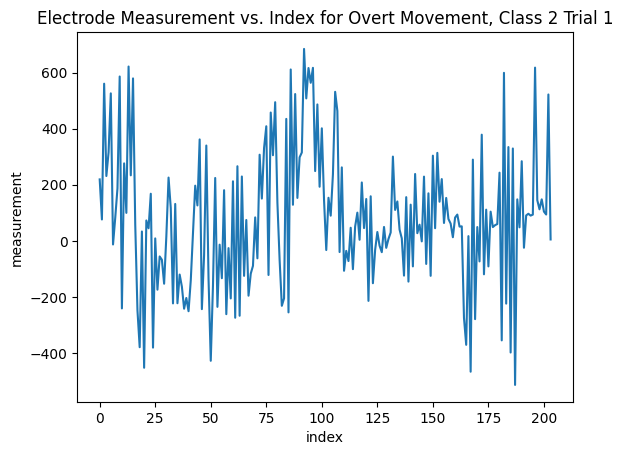

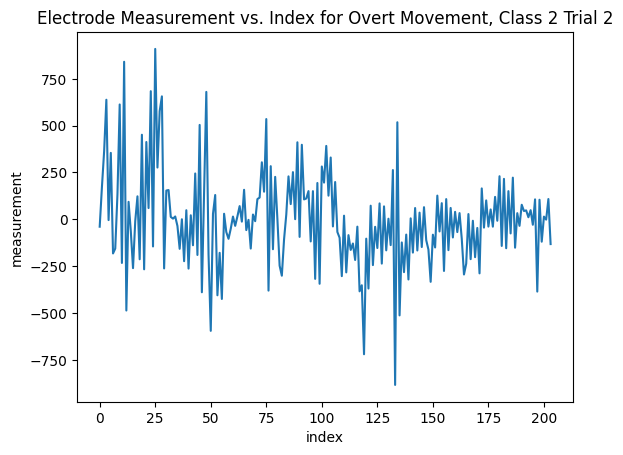

In [10]:
plot_electrode_values(feaSubEImg_1_df['trial 1'], plot_title='Electrode Measurement vs. Index for Imagined Movement, Class 1 Trial 1')
plot_electrode_values(feaSubEImg_1_df['trial 2'], plot_title='Electrode Measurement vs. Index for Imagined Movement, Class 1 Trial 2')
plot_electrode_values(feaSubEImg_2_df['trial 1'], plot_title='Electrode Measurement vs. Index for Imagined Movement, Class 2 Trial 1')
plot_electrode_values(feaSubEImg_2_df['trial 2'], plot_title='Electrode Measurement vs. Index for Imagined Movement, Class 2 Trial 2')

plot_electrode_values(feaSubEOvert_1_df['trial 1'], plot_title='Electrode Measurement vs. Index for Overt Movement, Class 1 Trial 1')
plot_electrode_values(feaSubEOvert_1_df['trial 2'], plot_title='Electrode Measurement vs. Index for Overt Movement, Class 1 Trial 2')
plot_electrode_values(feaSubEOvert_2_df['trial 1'], plot_title='Electrode Measurement vs. Index for Overt Movement, Class 2 Trial 1')
plot_electrode_values(feaSubEOvert_2_df['trial 2'], plot_title='Electrode Measurement vs. Index for Overt Movement, Class 2 Trial 2')

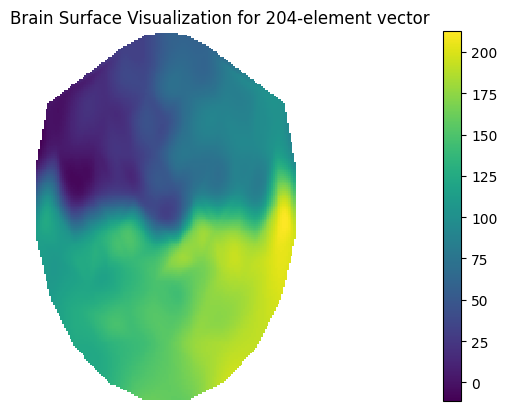

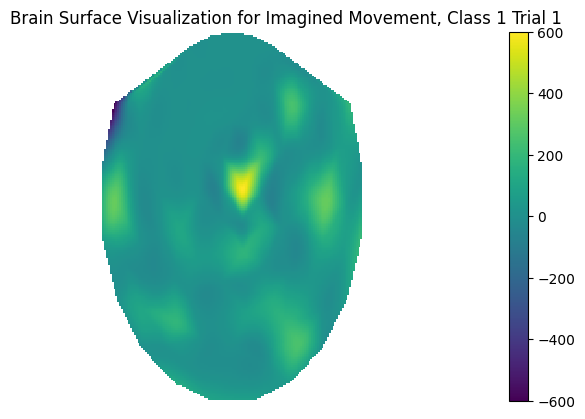

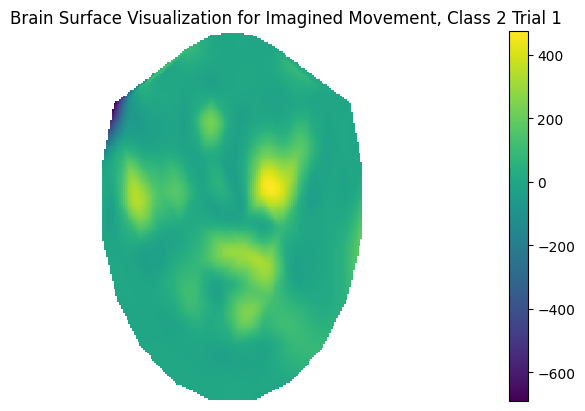

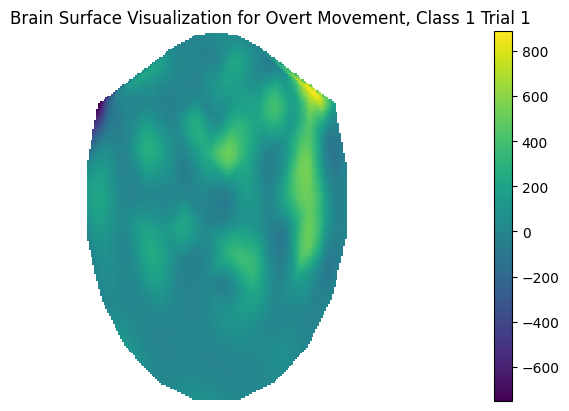

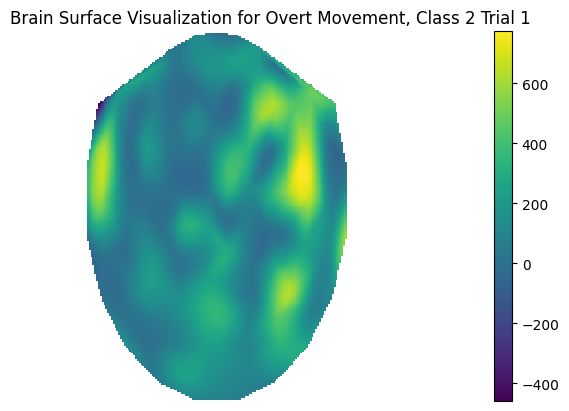

In [11]:
show_chanWeights(np.asarray(range(1, 205)), plot_title='Brain Surface Visualization for 204-element vector')
show_chanWeights(np.array(feaSubEImg_1_df['trial 1']), plot_title='Brain Surface Visualization for Imagined Movement, Class 1 Trial 1')
show_chanWeights(np.array(feaSubEImg_2_df['trial 1']), plot_title='Brain Surface Visualization for Imagined Movement, Class 2 Trial 1')
show_chanWeights(np.array(feaSubEOvert_1_df['trial 1']), plot_title='Brain Surface Visualization for Overt Movement, Class 1 Trial 1')
show_chanWeights(np.array(feaSubEOvert_2_df['trial 1']), plot_title='Brain Surface Visualization for Overt Movement, Class 2 Trial 1')

# CHECKPOINT 2

In [83]:
def plot_decision_statistic_kdes(feature_df_1, feature_df_2, y, plot_title):
    X = pd.concat([feature_df_1, feature_df_2], ignore_index=True, axis=0)
    clf = LinearSVC(max_iter=10_000)
    clf.fit(X, y)

    sns.kdeplot(data=clf.decision_function(feature_df_1), label='$f(λ|H_{0})$')
    sns.kdeplot(data=clf.decision_function(feature_df_2), label='$f(λ|H_{1})$')
    plt.legend()
    plt.title(plot_title)
    plt.show()

def plot_roc(X, y, roc_label, plot_title):
    clf = LinearSVC(max_iter=10_000)
    clf.fit(X, y)
    fpr, tpr, thresholds = roc_curve(y, clf.decision_function(X))
    plt.plot(fpr, tpr, label=roc_label)
    plt.plot(fpr, fpr, linestyle='dashed', label='random chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title(plot_title)
    plt.show()

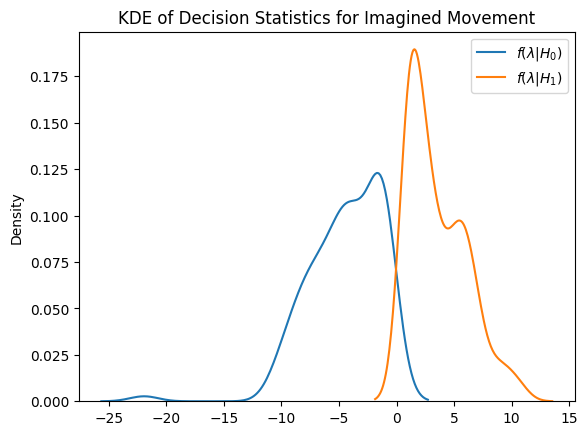

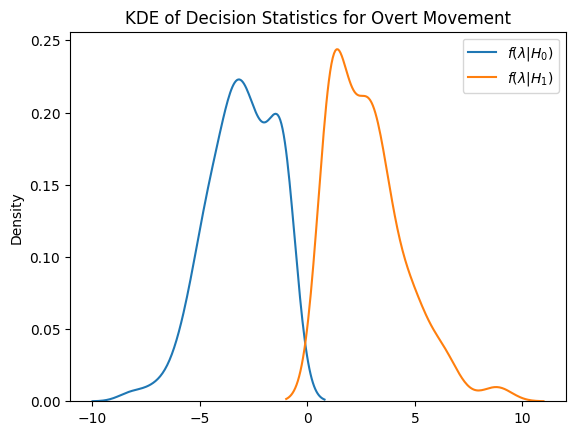

In [66]:
y = np.concatenate((np.zeros(N), np.ones(N)))
plot_decision_statistic_kdes(feaSubEImg_1_df.T, feaSubEImg_2_df.T, y, plot_title='KDE of Decision Statistics for Imagined Movement')
plot_decision_statistic_kdes(feaSubEOvert_1_df.T, feaSubEOvert_2_df.T, y, plot_title='KDE of Decision Statistics for Overt Movement')

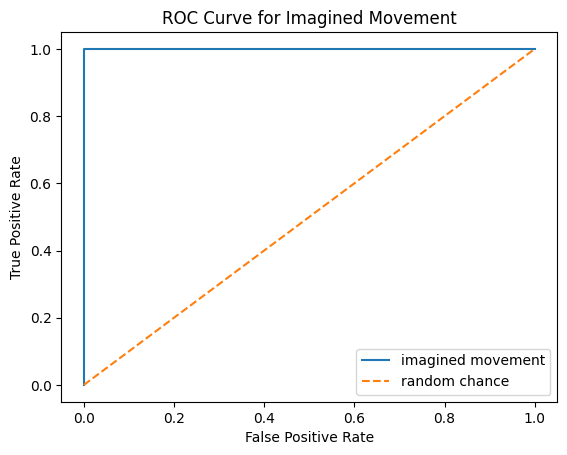

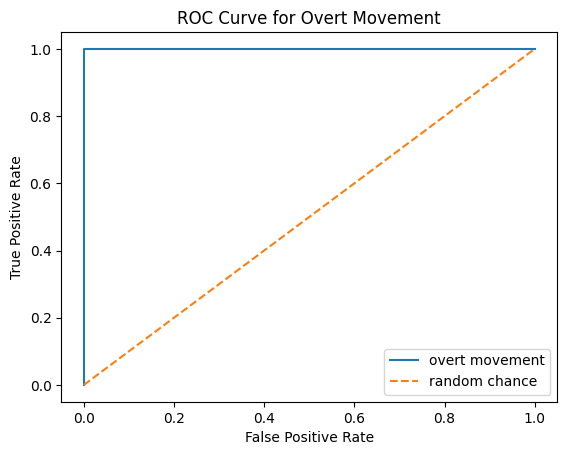

In [84]:
X_img = pd.concat([feaSubEImg_1_df.T, feaSubEImg_2_df.T], ignore_index=True, axis=0)
X_overt = pd.concat([feaSubEOvert_1_df.T, feaSubEOvert_2_df.T], ignore_index=True, axis=0)
y = np.concatenate((np.zeros(N), np.ones(N)))
plot_roc(X_img, y, roc_label='imagined movement', plot_title='ROC Curve for Imagined Movement')
plot_roc(X_overt, y, roc_label='overt movement', plot_title='ROC Curve for Overt Movement')